# Step 1. Getting the SEED dataset

## 1.1 load the matlab format files and take a look

In [1]:
import mne
from scipy import io
import os
import numpy as np

In [2]:
folderpath = "./Preprocessed_EEG"

In [3]:
raw_1_1 = io.loadmat('./Preprocessed_EEG/1_20131027.mat')
raw_1_2 = io.loadmat('./Preprocessed_EEG/1_20131030.mat')
raw_1_3 = io.loadmat('./Preprocessed_EEG/1_20131107.mat')
# raw_2_1 = scipy.io.loadmat('./Preprocessed_EEG/2_20140404.mat')
label = io.loadmat('./Preprocessed_EEG/label.mat')

In [4]:
raw_1_1.keys(), raw_1_2.keys(), raw_1_3.keys(), label.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'label']))

In [5]:
raw_1_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])

In [6]:
raw_1_1['djc_eeg2'].shape, raw_1_2['djc_eeg2'].shape, raw_1_1['djc_eeg10'].shape, raw_1_3['djc_eeg10'].shape

((62, 46601), (62, 46601), (62, 47401), (62, 47401))

raw_1_1['djc_eeg1']:
- raw_1_1: the raw eeg data, the 1st subject(out of 15 subjects), the 1st experiments(out of 3 experiments)
- 'djc_eeg1': djc could possibly mean the name of the subject(which leaks the privacy XD), and 'eeg1' represents it is the 1st trial(out of 15 trials)
- 62: n_channels
- 47001: roughly 4 mins(240sec * 200 Hz sampling rate) the eeg signal during watching the movies

In [7]:
label['label'][0]

array([ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1],
      dtype=int16)

## 1.2 Create the torch dataset

### 1.2.1 cut compute windows

since a movie clip contains eeg signals of ~240 seconds with sf=200Hz, I decide to cut them into 4 sec windows

In [8]:
len_window = 200 * 4

raw_X = []
raw_y = []

prefix = 'djc_eeg'

# raw_1_1
for i in range(1, 16):
    data = raw_1_1[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    data_list = []
    for idx in range(n_windows):
        cur_window = data[:, idx*len_window:(idx+1)*len_window]
        data_list.append(cur_window)
    reshaped_X = np.stack(data_list).transpose((1, 2, 0))
    # print(reshaped_X.shape)
    # reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))

# raw_1_2
for i in range(1, 16):
    data = raw_1_2[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    data_list = []
    for idx in range(n_windows):
        cur_window = data[:, idx*len_window:(idx+1)*len_window]
        data_list.append(cur_window)
    reshaped_X = np.stack(data_list).transpose((1, 2, 0))
    # print(reshaped_X.shape)
    # reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

# raw_1_3
for i in range(1, 16):
    data = raw_1_3[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    data_list = []
    for idx in range(n_windows):
        cur_window = data[:, idx*len_window:(idx+1)*len_window]
        data_list.append(cur_window)
    reshaped_X = np.stack(data_list).transpose((1, 2, 0))
    # print(reshaped_X.shape)
    # reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

In [9]:
concat_X = np.concatenate(raw_X, axis=2)
print(concat_X.shape)
concat_y = np.concatenate(raw_y)
print(concat_y.shape)

(62, 800, 2526)
(2526,)


### 1.2.2 Encode the labels

In [10]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [11]:
concat_y

array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16)

In [12]:
le = LabelEncoder()
y = le.fit_transform(concat_y)
y = pd.get_dummies(y)
y

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2521,1,0,0
2522,1,0,0
2523,1,0,0
2524,1,0,0


one-hot encoding
- positive:  1 => [0, 0 ,1]
- neutral:   0 => [0, 1, 0]
- negative: -1 => [1, 0, 0]

In [13]:
y.shape, concat_X.shape

((2526, 3), (62, 800, 2526))

# Step 2. Create EEG-conformer model

In [14]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib_inline

/home/pai/envs/fbc/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
cuda_version = torch.version.cuda
cuda_version

'11.7'

In [16]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) # input [n_batch, n_seq, n_inputsz=n_chans]
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        gru_output, _ = self.gru(x)
        flat = self.flatten(gru_output[:, -1: :])
        output = self.fc(flat)
        return output

# 定义模型输入、输出维度
input_size = 62 
hidden_size = 256
output_size = 3

# 创建模型实例
model = GRUModel(input_size, hidden_size, output_size)

# 打印模型结构
print(model)

GRUModel(
  (gru): GRU(62, 256, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [17]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)
    model.to(device)

the model will be trained on:  cuda


GRUModel(
  (gru): GRU(62, 256, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [18]:
from torchsummary import summary
summary(model, input_size=(32, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 32, 256], [-1, 2, 256]]               0
           Flatten-2                  [-1, 256]               0
            Linear-3                    [-1, 3]             771
Total params: 771
Trainable params: 771
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 32.00
Params size (MB): 0.00
Estimated Total Size (MB): 32.01
----------------------------------------------------------------


# Step 3. Training the model

## 3.1 prepare the train set / test set

In [19]:
concat_X.shape, y.shape

((62, 800, 2526), (2526, 3))

In [20]:
X = concat_X.transpose((2, 1, 0))
X.shape

(2526, 800, 62)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=777)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1768, 800, 62), (758, 800, 62), (1768, 3), (758, 3))

## 3.2 Training

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_train_tensor = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train.values).to(torch.float32).to(device)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_test_tensor = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test.values).to(torch.float32).to(device)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

In [25]:
def train(model, x_train, y_train, x_test, y_test, save_path='./model_gru/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list.clear()
    train_loss_list.clear()
    test_acc_list.clear()
    test_loss_list.clear()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)

    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in tqdm(train_loader):
            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("lables.size", labels.shape)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(labels, 1)
            # print(predicted.shape)
            total += labels.size(0)
            correct += (predicted == label).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()


                _, predicted = torch.max(outputs.data, 1)
                _, label = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == label).sum().item()
            
            test_loss = testing_loss / len(test_loader)
            test_loss_list.append(test_loss)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                if save_path is not None:
                    torch.save(model.state_dict(), save_path + 'best_model.pth')
                    print("best_model found, best acc: ", best_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None: 
        model.load_state_dict(torch.load(save_path + 'best_model.pth'))
    
    return model

In [26]:
best_model = train(model, X_train, X_test, y_train, y_test, n_epochs=100)

the model will be trained on:  cuda


100%|██████████| 56/56 [00:01<00:00, 30.11it/s]


best_model found, best acc:  0.3390501319261214
Epoch 1/100 - Train Loss: 1.1466 - Train Accuracy: 0.3535 - Test Loss: 1.1527 - Test Accuracy: 0.3391


100%|██████████| 56/56 [00:01<00:00, 36.15it/s]


Epoch 2/100 - Train Loss: 0.9682 - Train Accuracy: 0.5368 - Test Loss: 1.1647 - Test Accuracy: 0.3338


100%|██████████| 56/56 [00:01<00:00, 35.25it/s]


best_model found, best acc:  0.35356200527704484
Epoch 3/100 - Train Loss: 0.8833 - Train Accuracy: 0.6154 - Test Loss: 1.1710 - Test Accuracy: 0.3536


100%|██████████| 56/56 [00:01<00:00, 36.45it/s]


best_model found, best acc:  0.3733509234828496
Epoch 4/100 - Train Loss: 0.8057 - Train Accuracy: 0.6861 - Test Loss: 1.1588 - Test Accuracy: 0.3734


100%|██████████| 56/56 [00:01<00:00, 36.70it/s]


Epoch 5/100 - Train Loss: 0.7218 - Train Accuracy: 0.7279 - Test Loss: 1.2135 - Test Accuracy: 0.3602


100%|██████████| 56/56 [00:01<00:00, 36.56it/s]


Epoch 6/100 - Train Loss: 0.6541 - Train Accuracy: 0.7596 - Test Loss: 1.2370 - Test Accuracy: 0.3720


100%|██████████| 56/56 [00:01<00:00, 36.75it/s]


Epoch 7/100 - Train Loss: 0.5891 - Train Accuracy: 0.7771 - Test Loss: 1.2853 - Test Accuracy: 0.3668


100%|██████████| 56/56 [00:01<00:00, 35.20it/s]


Epoch 8/100 - Train Loss: 0.5377 - Train Accuracy: 0.7862 - Test Loss: 1.2763 - Test Accuracy: 0.3536


100%|██████████| 56/56 [00:01<00:00, 35.95it/s]


Epoch 9/100 - Train Loss: 0.4865 - Train Accuracy: 0.8077 - Test Loss: 1.3022 - Test Accuracy: 0.3668


100%|██████████| 56/56 [00:01<00:00, 36.43it/s]


best_model found, best acc:  0.3759894459102902
Epoch 10/100 - Train Loss: 0.4450 - Train Accuracy: 0.8230 - Test Loss: 1.3456 - Test Accuracy: 0.3760


100%|██████████| 56/56 [00:01<00:00, 36.14it/s]


Epoch 11/100 - Train Loss: 0.4097 - Train Accuracy: 0.8247 - Test Loss: 1.3458 - Test Accuracy: 0.3615


100%|██████████| 56/56 [00:01<00:00, 35.99it/s]


Epoch 12/100 - Train Loss: 0.3928 - Train Accuracy: 0.8269 - Test Loss: 1.3666 - Test Accuracy: 0.3707


100%|██████████| 56/56 [00:01<00:00, 35.86it/s]


Epoch 13/100 - Train Loss: 0.3828 - Train Accuracy: 0.8179 - Test Loss: 1.4085 - Test Accuracy: 0.3483


100%|██████████| 56/56 [00:01<00:00, 36.06it/s]


Epoch 14/100 - Train Loss: 0.3649 - Train Accuracy: 0.8286 - Test Loss: 1.4179 - Test Accuracy: 0.3641


100%|██████████| 56/56 [00:01<00:00, 36.61it/s]


Epoch 15/100 - Train Loss: 0.3602 - Train Accuracy: 0.8258 - Test Loss: 1.4397 - Test Accuracy: 0.3575


100%|██████████| 56/56 [00:01<00:00, 36.22it/s]


Epoch 16/100 - Train Loss: 0.3546 - Train Accuracy: 0.8252 - Test Loss: 1.4460 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 35.84it/s]


Epoch 17/100 - Train Loss: 0.3442 - Train Accuracy: 0.8343 - Test Loss: 1.4520 - Test Accuracy: 0.3707


100%|██████████| 56/56 [00:01<00:00, 36.34it/s]


best_model found, best acc:  0.37994722955145116
Epoch 18/100 - Train Loss: 0.3345 - Train Accuracy: 0.8394 - Test Loss: 1.4711 - Test Accuracy: 0.3799


100%|██████████| 56/56 [00:01<00:00, 35.58it/s]


Epoch 19/100 - Train Loss: 0.3357 - Train Accuracy: 0.8281 - Test Loss: 1.4876 - Test Accuracy: 0.3615


100%|██████████| 56/56 [00:01<00:00, 36.10it/s]


Epoch 20/100 - Train Loss: 0.3234 - Train Accuracy: 0.8484 - Test Loss: 1.4935 - Test Accuracy: 0.3562


100%|██████████| 56/56 [00:01<00:00, 35.95it/s]


Epoch 21/100 - Train Loss: 0.3260 - Train Accuracy: 0.8331 - Test Loss: 1.5168 - Test Accuracy: 0.3522


100%|██████████| 56/56 [00:01<00:00, 35.88it/s]


Epoch 22/100 - Train Loss: 0.3296 - Train Accuracy: 0.8343 - Test Loss: 1.5366 - Test Accuracy: 0.3509


100%|██████████| 56/56 [00:01<00:00, 36.50it/s]


Epoch 23/100 - Train Loss: 0.3267 - Train Accuracy: 0.8422 - Test Loss: 1.5445 - Test Accuracy: 0.3668


100%|██████████| 56/56 [00:01<00:00, 35.29it/s]


Epoch 24/100 - Train Loss: 0.3191 - Train Accuracy: 0.8365 - Test Loss: 1.5398 - Test Accuracy: 0.3641


100%|██████████| 56/56 [00:01<00:00, 36.01it/s]


Epoch 25/100 - Train Loss: 0.3165 - Train Accuracy: 0.8394 - Test Loss: 1.5554 - Test Accuracy: 0.3668


100%|██████████| 56/56 [00:01<00:00, 35.87it/s]


Epoch 26/100 - Train Loss: 0.3258 - Train Accuracy: 0.8264 - Test Loss: 1.5667 - Test Accuracy: 0.3668


100%|██████████| 56/56 [00:01<00:00, 36.07it/s]


Epoch 27/100 - Train Loss: 0.3186 - Train Accuracy: 0.8286 - Test Loss: 1.5784 - Test Accuracy: 0.3575


100%|██████████| 56/56 [00:01<00:00, 36.05it/s]


Epoch 28/100 - Train Loss: 0.3125 - Train Accuracy: 0.8450 - Test Loss: 1.5991 - Test Accuracy: 0.3496


100%|██████████| 56/56 [00:01<00:00, 35.92it/s]


Epoch 29/100 - Train Loss: 0.3150 - Train Accuracy: 0.8360 - Test Loss: 1.6277 - Test Accuracy: 0.3522


100%|██████████| 56/56 [00:01<00:00, 35.02it/s]


Epoch 30/100 - Train Loss: 0.3068 - Train Accuracy: 0.8399 - Test Loss: 1.6342 - Test Accuracy: 0.3575


100%|██████████| 56/56 [00:01<00:00, 36.56it/s]


Epoch 31/100 - Train Loss: 0.3033 - Train Accuracy: 0.8462 - Test Loss: 1.6340 - Test Accuracy: 0.3641


100%|██████████| 56/56 [00:01<00:00, 36.11it/s]


Epoch 32/100 - Train Loss: 0.3079 - Train Accuracy: 0.8501 - Test Loss: 1.6407 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 36.25it/s]


Epoch 33/100 - Train Loss: 0.3082 - Train Accuracy: 0.8484 - Test Loss: 1.6469 - Test Accuracy: 0.3509


100%|██████████| 56/56 [00:01<00:00, 36.20it/s]


Epoch 34/100 - Train Loss: 0.3099 - Train Accuracy: 0.8433 - Test Loss: 1.6452 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 34.36it/s]


Epoch 35/100 - Train Loss: 0.3098 - Train Accuracy: 0.8382 - Test Loss: 1.6483 - Test Accuracy: 0.3443


100%|██████████| 56/56 [00:01<00:00, 35.59it/s]


Epoch 36/100 - Train Loss: 0.3068 - Train Accuracy: 0.8495 - Test Loss: 1.6599 - Test Accuracy: 0.3470


100%|██████████| 56/56 [00:01<00:00, 36.21it/s]


Epoch 37/100 - Train Loss: 0.2934 - Train Accuracy: 0.8535 - Test Loss: 1.6843 - Test Accuracy: 0.3575


100%|██████████| 56/56 [00:01<00:00, 35.90it/s]


Epoch 38/100 - Train Loss: 0.3104 - Train Accuracy: 0.8433 - Test Loss: 1.6874 - Test Accuracy: 0.3549


100%|██████████| 56/56 [00:01<00:00, 36.45it/s]


Epoch 39/100 - Train Loss: 0.3000 - Train Accuracy: 0.8495 - Test Loss: 1.6879 - Test Accuracy: 0.3641


100%|██████████| 56/56 [00:01<00:00, 35.44it/s]


Epoch 40/100 - Train Loss: 0.2954 - Train Accuracy: 0.8518 - Test Loss: 1.6997 - Test Accuracy: 0.3509


100%|██████████| 56/56 [00:01<00:00, 35.60it/s]


Epoch 41/100 - Train Loss: 0.2957 - Train Accuracy: 0.8507 - Test Loss: 1.7135 - Test Accuracy: 0.3588


100%|██████████| 56/56 [00:01<00:00, 36.24it/s]


Epoch 42/100 - Train Loss: 0.2936 - Train Accuracy: 0.8524 - Test Loss: 1.6923 - Test Accuracy: 0.3747


100%|██████████| 56/56 [00:01<00:00, 36.12it/s]


Epoch 43/100 - Train Loss: 0.2941 - Train Accuracy: 0.8512 - Test Loss: 1.7151 - Test Accuracy: 0.3549


100%|██████████| 56/56 [00:01<00:00, 35.50it/s]


Epoch 44/100 - Train Loss: 0.2932 - Train Accuracy: 0.8614 - Test Loss: 1.7300 - Test Accuracy: 0.3720


100%|██████████| 56/56 [00:01<00:00, 36.15it/s]


Epoch 45/100 - Train Loss: 0.2970 - Train Accuracy: 0.8592 - Test Loss: 1.7395 - Test Accuracy: 0.3615


100%|██████████| 56/56 [00:01<00:00, 33.85it/s]


Epoch 46/100 - Train Loss: 0.2901 - Train Accuracy: 0.8546 - Test Loss: 1.7609 - Test Accuracy: 0.3681


100%|██████████| 56/56 [00:01<00:00, 36.44it/s]


best_model found, best acc:  0.38522427440633245
Epoch 47/100 - Train Loss: 0.2942 - Train Accuracy: 0.8524 - Test Loss: 1.7713 - Test Accuracy: 0.3852


100%|██████████| 56/56 [00:01<00:00, 35.67it/s]


Epoch 48/100 - Train Loss: 0.2967 - Train Accuracy: 0.8484 - Test Loss: 1.7566 - Test Accuracy: 0.3813


100%|██████████| 56/56 [00:01<00:00, 35.98it/s]


Epoch 49/100 - Train Loss: 0.2967 - Train Accuracy: 0.8473 - Test Loss: 1.7524 - Test Accuracy: 0.3707


100%|██████████| 56/56 [00:01<00:00, 36.18it/s]


Epoch 50/100 - Train Loss: 0.2842 - Train Accuracy: 0.8569 - Test Loss: 1.7859 - Test Accuracy: 0.3668


100%|██████████| 56/56 [00:01<00:00, 33.10it/s]


Epoch 51/100 - Train Loss: 0.2964 - Train Accuracy: 0.8495 - Test Loss: 1.7962 - Test Accuracy: 0.3773


100%|██████████| 56/56 [00:01<00:00, 35.76it/s]


Epoch 52/100 - Train Loss: 0.2969 - Train Accuracy: 0.8501 - Test Loss: 1.8092 - Test Accuracy: 0.3773


100%|██████████| 56/56 [00:01<00:00, 36.09it/s]


Epoch 53/100 - Train Loss: 0.2948 - Train Accuracy: 0.8524 - Test Loss: 1.8185 - Test Accuracy: 0.3654


100%|██████████| 56/56 [00:01<00:00, 36.14it/s]


Epoch 54/100 - Train Loss: 0.2946 - Train Accuracy: 0.8462 - Test Loss: 1.8594 - Test Accuracy: 0.3786


100%|██████████| 56/56 [00:01<00:00, 36.32it/s]


Epoch 55/100 - Train Loss: 0.2948 - Train Accuracy: 0.8518 - Test Loss: 1.8710 - Test Accuracy: 0.3707


100%|██████████| 56/56 [00:01<00:00, 35.58it/s]


Epoch 56/100 - Train Loss: 0.2890 - Train Accuracy: 0.8524 - Test Loss: 1.8713 - Test Accuracy: 0.3786


100%|██████████| 56/56 [00:01<00:00, 35.86it/s]


Epoch 57/100 - Train Loss: 0.3417 - Train Accuracy: 0.8365 - Test Loss: 1.9164 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 36.07it/s]


Epoch 58/100 - Train Loss: 1.1585 - Train Accuracy: 0.5113 - Test Loss: 1.5180 - Test Accuracy: 0.3747


100%|██████████| 56/56 [00:01<00:00, 36.07it/s]


Epoch 59/100 - Train Loss: 0.9380 - Train Accuracy: 0.5571 - Test Loss: 1.4161 - Test Accuracy: 0.3707


100%|██████████| 56/56 [00:01<00:00, 35.61it/s]


Epoch 60/100 - Train Loss: 0.7438 - Train Accuracy: 0.6533 - Test Loss: 1.4126 - Test Accuracy: 0.3549


100%|██████████| 56/56 [00:01<00:00, 36.30it/s]


Epoch 61/100 - Train Loss: 0.6166 - Train Accuracy: 0.7319 - Test Loss: 1.4251 - Test Accuracy: 0.3681


100%|██████████| 56/56 [00:01<00:00, 34.35it/s]


Epoch 62/100 - Train Loss: 0.5250 - Train Accuracy: 0.7913 - Test Loss: 1.3942 - Test Accuracy: 0.3839


100%|██████████| 56/56 [00:01<00:00, 36.19it/s]


Epoch 63/100 - Train Loss: 0.4561 - Train Accuracy: 0.8139 - Test Loss: 1.4249 - Test Accuracy: 0.3799


100%|██████████| 56/56 [00:01<00:00, 35.98it/s]


Epoch 64/100 - Train Loss: 0.4151 - Train Accuracy: 0.8309 - Test Loss: 1.4536 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 36.00it/s]


Epoch 65/100 - Train Loss: 0.3869 - Train Accuracy: 0.8382 - Test Loss: 1.4710 - Test Accuracy: 0.3575


100%|██████████| 56/56 [00:01<00:00, 35.82it/s]


Epoch 66/100 - Train Loss: 0.3767 - Train Accuracy: 0.8314 - Test Loss: 1.4507 - Test Accuracy: 0.3654


100%|██████████| 56/56 [00:01<00:00, 34.76it/s]


Epoch 67/100 - Train Loss: 0.3643 - Train Accuracy: 0.8303 - Test Loss: 1.4657 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 35.98it/s]


Epoch 68/100 - Train Loss: 0.3392 - Train Accuracy: 0.8467 - Test Loss: 1.4802 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 35.89it/s]


Epoch 69/100 - Train Loss: 0.3418 - Train Accuracy: 0.8399 - Test Loss: 1.5040 - Test Accuracy: 0.3522


100%|██████████| 56/56 [00:01<00:00, 36.44it/s]


Epoch 70/100 - Train Loss: 0.3352 - Train Accuracy: 0.8388 - Test Loss: 1.5098 - Test Accuracy: 0.3602


100%|██████████| 56/56 [00:01<00:00, 36.59it/s]


Epoch 71/100 - Train Loss: 0.3327 - Train Accuracy: 0.8337 - Test Loss: 1.5123 - Test Accuracy: 0.3681


100%|██████████| 56/56 [00:01<00:00, 35.85it/s]


Epoch 72/100 - Train Loss: 0.3203 - Train Accuracy: 0.8433 - Test Loss: 1.5080 - Test Accuracy: 0.3654


100%|██████████| 56/56 [00:01<00:00, 35.93it/s]


Epoch 73/100 - Train Loss: 0.3179 - Train Accuracy: 0.8524 - Test Loss: 1.5216 - Test Accuracy: 0.3602


100%|██████████| 56/56 [00:01<00:00, 36.39it/s]


Epoch 74/100 - Train Loss: 0.3210 - Train Accuracy: 0.8416 - Test Loss: 1.5124 - Test Accuracy: 0.3602


100%|██████████| 56/56 [00:01<00:00, 35.71it/s]


Epoch 75/100 - Train Loss: 0.3131 - Train Accuracy: 0.8569 - Test Loss: 1.5096 - Test Accuracy: 0.3615


100%|██████████| 56/56 [00:01<00:00, 36.47it/s]


Epoch 76/100 - Train Loss: 0.3161 - Train Accuracy: 0.8518 - Test Loss: 1.5268 - Test Accuracy: 0.3681


100%|██████████| 56/56 [00:01<00:00, 36.21it/s]


Epoch 77/100 - Train Loss: 0.3078 - Train Accuracy: 0.8512 - Test Loss: 1.5478 - Test Accuracy: 0.3773


100%|██████████| 56/56 [00:01<00:00, 33.55it/s]


Epoch 78/100 - Train Loss: 0.3057 - Train Accuracy: 0.8445 - Test Loss: 1.5473 - Test Accuracy: 0.3681


100%|██████████| 56/56 [00:01<00:00, 36.45it/s]


Epoch 79/100 - Train Loss: 0.3034 - Train Accuracy: 0.8484 - Test Loss: 1.5572 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 36.17it/s]


Epoch 80/100 - Train Loss: 0.3060 - Train Accuracy: 0.8462 - Test Loss: 1.5568 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 35.84it/s]


Epoch 81/100 - Train Loss: 0.3012 - Train Accuracy: 0.8484 - Test Loss: 1.5618 - Test Accuracy: 0.3549


100%|██████████| 56/56 [00:01<00:00, 36.47it/s]


Epoch 82/100 - Train Loss: 0.3057 - Train Accuracy: 0.8518 - Test Loss: 1.5592 - Test Accuracy: 0.3549


100%|██████████| 56/56 [00:01<00:00, 36.55it/s]


Epoch 83/100 - Train Loss: 0.3056 - Train Accuracy: 0.8512 - Test Loss: 1.5739 - Test Accuracy: 0.3615


100%|██████████| 56/56 [00:01<00:00, 35.42it/s]


Epoch 84/100 - Train Loss: 0.3005 - Train Accuracy: 0.8512 - Test Loss: 1.5798 - Test Accuracy: 0.3575


100%|██████████| 56/56 [00:01<00:00, 35.97it/s]


Epoch 85/100 - Train Loss: 0.3112 - Train Accuracy: 0.8388 - Test Loss: 1.5829 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 35.74it/s]


Epoch 86/100 - Train Loss: 0.3039 - Train Accuracy: 0.8620 - Test Loss: 1.5830 - Test Accuracy: 0.3602


100%|██████████| 56/56 [00:01<00:00, 36.22it/s]


Epoch 87/100 - Train Loss: 0.2974 - Train Accuracy: 0.8524 - Test Loss: 1.5757 - Test Accuracy: 0.3536


100%|██████████| 56/56 [00:01<00:00, 35.88it/s]


Epoch 88/100 - Train Loss: 0.2897 - Train Accuracy: 0.8603 - Test Loss: 1.5720 - Test Accuracy: 0.3747


100%|██████████| 56/56 [00:01<00:00, 36.17it/s]


Epoch 89/100 - Train Loss: 0.2890 - Train Accuracy: 0.8637 - Test Loss: 1.6031 - Test Accuracy: 0.3641


100%|██████████| 56/56 [00:01<00:00, 36.63it/s]


Epoch 90/100 - Train Loss: 0.2938 - Train Accuracy: 0.8518 - Test Loss: 1.6316 - Test Accuracy: 0.3562


100%|██████████| 56/56 [00:01<00:00, 36.40it/s]


Epoch 91/100 - Train Loss: 0.2886 - Train Accuracy: 0.8586 - Test Loss: 1.6344 - Test Accuracy: 0.3615


100%|██████████| 56/56 [00:01<00:00, 36.21it/s]


Epoch 92/100 - Train Loss: 0.2906 - Train Accuracy: 0.8603 - Test Loss: 1.6216 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 36.36it/s]


Epoch 93/100 - Train Loss: 0.2840 - Train Accuracy: 0.8733 - Test Loss: 1.6091 - Test Accuracy: 0.3602


100%|██████████| 56/56 [00:01<00:00, 34.79it/s]


Epoch 94/100 - Train Loss: 0.2900 - Train Accuracy: 0.8603 - Test Loss: 1.6260 - Test Accuracy: 0.3720


100%|██████████| 56/56 [00:01<00:00, 35.82it/s]


Epoch 95/100 - Train Loss: 0.2709 - Train Accuracy: 0.8750 - Test Loss: 1.6228 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 36.13it/s]


Epoch 96/100 - Train Loss: 0.2796 - Train Accuracy: 0.8761 - Test Loss: 1.6596 - Test Accuracy: 0.3496


100%|██████████| 56/56 [00:01<00:00, 36.42it/s]


Epoch 97/100 - Train Loss: 0.2786 - Train Accuracy: 0.8761 - Test Loss: 1.6378 - Test Accuracy: 0.3628


100%|██████████| 56/56 [00:01<00:00, 36.35it/s]


Epoch 98/100 - Train Loss: 0.2835 - Train Accuracy: 0.8654 - Test Loss: 1.6660 - Test Accuracy: 0.3562


100%|██████████| 56/56 [00:01<00:00, 35.56it/s]


Epoch 99/100 - Train Loss: 0.2795 - Train Accuracy: 0.8648 - Test Loss: 1.6644 - Test Accuracy: 0.3694


100%|██████████| 56/56 [00:01<00:00, 35.04it/s]


Epoch 100/100 - Train Loss: 0.2755 - Train Accuracy: 0.8744 - Test Loss: 1.6621 - Test Accuracy: 0.3773


# Step 4. Assessment

## 4.1 Training plot

In [27]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'epoch')

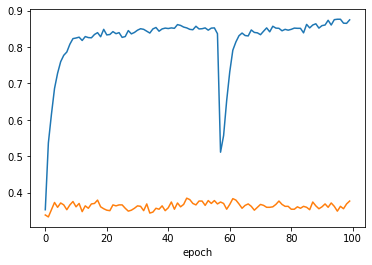

In [28]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

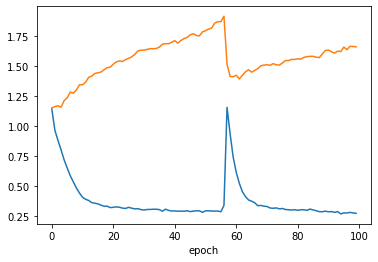

In [29]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

## 4.2 Model Evaluation

In [30]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, label = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.3852
